Calculate and plot meridional heat transport
Uses two methods because of diagnostics available:
From surface heat flux assuming steady state
From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [129]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as c
from dask.distributed import Client


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [86]:
#old school MHYT method works fine. Cookbook is broken.

#read 1 deg ATl. mask
NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'
Ocean_File = os.path.join(NYFCntrlDir,'om2_1_amoc_mask.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.kmu.shape)
mask=cntrl.kmu[0].load()
mask=np.nan_to_num(mask)

#print(mask.shape) 
#latv = np.zeros((300,1),)
#latv[:,0]=np.nan_to_num(cntrl.yu_ocean.load())
#print(latv.shape)  

Ocean_File = os.path.join(NYFCntrlDir,'adv_temp_yflux_1degB1_iaf.057to059.ncra.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#pert=xr.open_mfdataset(Ocean_File, concat_dim='time', decode_times=False, preprocess=lambda d: d['ty_trans'].to_dataset())

print(cntrl.temp_yflux_adv_int_z.shape)
print(cntrl.temp_yflux_submeso_int_z.shape)
print(cntrl.temp_yflux_gm_int_z.shape)
print(cntrl.temp_yflux_ndiffuse_int_z.shape)

latv1=cntrl.yu_ocean.load()
print(latv1)

y1=cntrl.temp_yflux_adv_int_z*mask
y2=cntrl.temp_yflux_submeso_int_z*mask
y3=cntrl.temp_yflux_gm_int_z*mask
y4=cntrl.temp_yflux_ndiffuse_int_z*mask

MHF1 = cntrl.temp_yflux_adv_int_z.sum('xt_ocean').load()+cntrl.temp_yflux_submeso_int_z.sum('xt_ocean').load() + cntrl.temp_yflux_gm_int_z.sum('xt_ocean').load()+cntrl.temp_yflux_ndiffuse_int_z.sum('xt_ocean').load()
atlMHF1 = y1.sum('xt_ocean').load()+y2.sum('xt_ocean').load()+y3.sum('xt_ocean').load()+y4.sum('xt_ocean').load()
print(MHF1.values)





/g/data1/v45/pas561/access-om2_amoc/om2_1_amoc_mask.nc
(1, 300, 360)
/g/data1/v45/pas561/access-om2_amoc/adv_temp_yflux_1degB1_iaf.057to059.ncra.nc
(1, 300, 360)
(1, 300, 360)
(1, 300, 360)
(1, 300, 360)
<xarray.DataArray 'yu_ocean' (yu_ocean: 300)>
array([-77.753168, -77.50571 , -77.256999, ...,  89.098469,  89.549241,
        90.      ])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
[[ 0.00000000e+00 -4.78177886e+11 -8.50406474e+11 -1.23042411e+12
  -1.58132024e+12 -2.00812764e+12 -2.19829685e+12 -2.77387700e+12
  -3.41552634e+12 -4.08340555e+12 -4.64595819e+12 -5.81075154e+12
  -6.86392502e+12 -8.09055761e+12 -9.91953106e+12 -1.21688996e+13
  -1.48088732e+13 -1.78839796e+13 -2.11796372e+13 -2.42565492e+13
  -2.90927600e+13 -3.42746779e+13 -3.98877010e+13 -4.57628682e+13
  -5.16151637e+13 -5.84389776e+13 -6.74111391e+13 -7.73225059e+13


In [87]:

#read 1 deg ATl. mask
NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'
Ocean_File = os.path.join(NYFCntrlDir,'om2_025_amoc_mask.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.kmu.shape)
mask=cntrl.kmu[0].load()
mask=np.nan_to_num(mask)

#print(mask.shape) 
#latv = np.zeros((300,1),)
#latv[:,0]=np.nan_to_num(cntrl.yu_ocean.load())
#print(latv.shape)  

Ocean_File = os.path.join(NYFCntrlDir,'adv_temp_yflux_025gmredi6_iaf.140to153.ncra.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#pert=xr.open_mfdataset(Ocean_File, concat_dim='time', decode_times=False, preprocess=lambda d: d['ty_trans'].to_dataset())

print(cntrl.temp_yflux_adv_int_z.shape)
print(cntrl.temp_yflux_submeso_int_z.shape)
print(cntrl.temp_yflux_gm_int_z.shape)
print(cntrl.temp_yflux_ndiffuse_int_z.shape)

latv025=cntrl.yu_ocean.load()
print(latv025)

y1=cntrl.temp_yflux_adv_int_z*mask
y2=cntrl.temp_yflux_submeso_int_z*mask
y3=cntrl.temp_yflux_gm_int_z*mask
y4=cntrl.temp_yflux_ndiffuse_int_z*mask

MHF025 = cntrl.temp_yflux_adv_int_z.sum('xt_ocean').load()+cntrl.temp_yflux_submeso_int_z.sum('xt_ocean').load() + cntrl.temp_yflux_gm_int_z.sum('xt_ocean').load()+cntrl.temp_yflux_ndiffuse_int_z.sum('xt_ocean').load()
atlMHF025 = y1.sum('xt_ocean').load()+y2.sum('xt_ocean').load()+y3.sum('xt_ocean').load()+y4.sum('xt_ocean').load()
print(MHF025.values)





/g/data1/v45/pas561/access-om2_amoc/om2_025_amoc_mask.nc
(1, 1080, 1440)
/g/data1/v45/pas561/access-om2_amoc/adv_temp_yflux_025gmredi6_iaf.140to153.ncra.nc
(1, 1080, 1440)
(1, 1080, 1440)
(1, 1080, 1440)
(1, 1080, 1440)
<xarray.DataArray 'yu_ocean' (yu_ocean: 1080)>
array([-81.024202, -80.918603, -80.813004, ...,  89.788884,  89.894483,
        90.      ])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.9941404e+11
   9.1132961e+10 -1.2826406e+09]]


In [88]:
#read 1 deg ATl. mask
NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'
Ocean_File = os.path.join(NYFCntrlDir,'om2_01_amoc_mask_newdims.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.kmu.shape)
mask=cntrl.kmu[0].load()
mask=np.nan_to_num(mask)

#print(mask.shape) 
#latv = np.zeros((300,1),)
#latv[:,0]=np.nan_to_num(cntrl.yu_ocean.load())
#print(latv.shape)  

Ocean_File = os.path.join(NYFCntrlDir,'adv_temp_yflux_01iaf85.150to197.2010-2018.ncra.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#pert=xr.open_mfdataset(Ocean_File, concat_dim='time', decode_times=False, preprocess=lambda d: d['ty_trans'].to_dataset())

print(cntrl.temp_yflux_adv_int_z.shape)
print(cntrl.temp_yflux_submeso_int_z.shape)

latv01=cntrl.yu_ocean.load()
print(latv01)

y1=cntrl.temp_yflux_adv_int_z*mask
y2=cntrl.temp_yflux_submeso_int_z*mask

MHF01 = cntrl.temp_yflux_adv_int_z.sum('xt_ocean').load()+cntrl.temp_yflux_submeso_int_z.sum('xt_ocean').load() 
atlMHF01 = y1.sum('xt_ocean').load()+y2.sum('xt_ocean').load()
print(MHF01.values)


/g/data1/v45/pas561/access-om2_amoc/om2_01_amoc_mask_newdims.nc
(1, 2700, 3600)
/g/data1/v45/pas561/access-om2_amoc/adv_temp_yflux_01iaf85.150to197.2010-2018.ncra.nc
(1, 2700, 3600)
(1, 2700, 3600)
<xarray.DataArray 'yu_ocean' (yu_ocean: 2700)>
array([-81.087512, -81.045273, -81.003033, ...,  89.915537,  89.957776,
        90.      ])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5292636e+11
   7.3545671e+10 -8.7021152e+08]]


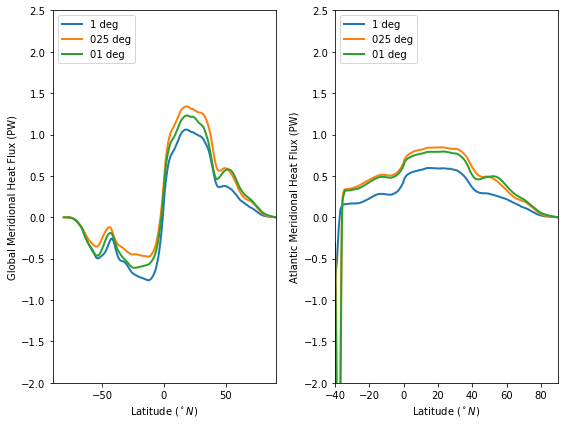

In [93]:
# plot both surface heat flux, temp_yflux_adv methods and observations:
fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(latv1.values[:],MHF1.values[0,:]/1.e15,linewidth=2,label='1 deg')
plt.plot(latv025.values[:],MHF025.values[0,:]/1.e15,linewidth=2,label='025 deg')
plt.plot(latv01.values[:],MHF01.values[0,:]/1.e15,linewidth=2,label='01 deg')
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Global Meridional Heat Flux (PW)')

#plt.plot(MHF/1.e15,linewidth=2)
#plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
#plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
#plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dk',capsize=5,label='GW2003')
#plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend(loc=2)
plt.xlim([-90.,90.])
plt.ylim([-2, 2.5])

plt.subplot(122)
plt.plot(latv1.values[:],atlMHF1.values[0,:]/1.e15,linewidth=2,label='1 deg')
plt.plot(latv025.values[:],atlMHF025.values[0,:]/1.e15,linewidth=2,label='025 deg')
plt.plot(latv01.values[:],atlMHF01.values[0,:]/1.e15,linewidth=2,label='01 deg')
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Atlantic Meridional Heat Flux (PW)')

#plt.plot(MHF/1.e15,linewidth=2)
#plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
#plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
#plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dk',capsize=5,label='GW2003')
#plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend(loc=2)
plt.xlim([-40.,90.])
plt.ylim([-2, 2.5])
plt.tight_layout()

In [131]:
np.savetxt('/g/data1/v45/pas561/access-om2_amoc/ACCESS-0M2-1_AtlMHT.txt', (atlMHF1.values[0,:],latv1.values[:]),delimiter=' ',newline='\n')#,fmt='%1.4e, %5f',delimiter=' ')   # use exponential notation
np.savetxt('/g/data1/v45/pas561/access-om2_amoc/ACCESS-0M2-025_AtlMHT.txt', (atlMHF025.values[0,:],latv025.values[:]),delimiter=' ',newline='\n')#,fmt='%1.4e, %5f',delimiter=' ')   # use exponential notation
np.savetxt('/g/data1/v45/pas561/access-om2_amoc/ACCESS-0M2-01_AtlMHT.txt', (atlMHF01.values[0,:],latv01.values[:]),delimiter=' ',newline='\n')#,fmt='%1.4e, %5f',delimiter=' ')   # use exponential notation

(2, 300) (2, 1080) (2, 2700)


(-2, 2.5)

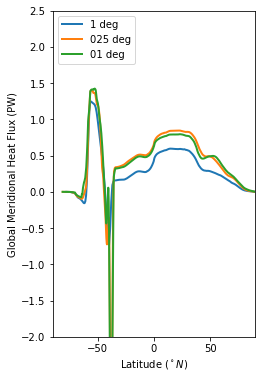

In [134]:
tst1=np.loadtxt('/g/data1/v45/pas561/access-om2_amoc/ACCESS-0M2-1_AtlMHT.txt')
tst2=np.loadtxt('/g/data1/v45/pas561/access-om2_amoc/ACCESS-0M2-025_AtlMHT.txt')
tst3=np.loadtxt('/g/data1/v45/pas561/access-om2_amoc/ACCESS-0M2-01_AtlMHT.txt')
print(tst1.shape,tst2.shape,tst3.shape)

fig = plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(tst1[1,:],tst1[0,:]/1.e15,linewidth=2,label='1 deg')
plt.plot(tst2[1,:],tst2[0,:]/1.e15,linewidth=2,label='025 deg')
plt.plot(tst3[1,:],tst3[0,:]/1.e15,linewidth=2,label='01 deg')
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Global Meridional Heat Flux (PW)')

#plt.plot(MHF/1.e15,linewidth=2)
#plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
#plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
#plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dk',capsize=5,label='GW2003')
#plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend(loc=2)
plt.xlim([-90.,90.])
plt.ylim([-2, 2.5])

In [2]:
# Set 1-degree data to be different for MHT diagnostics:
exptdata.exptdict['1deg']['exptdir'] = '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle'
exptdata.exptdict['1deg']['expt'] = '1deg_jra55v13_iaf_spinup1_B1_lastcycle'

tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [3]:
figdir = '/g/data1/v45/pas561/access-om2_amoc/'
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
## This is the method we use to get around memory issues. To implement, use:
## dask-scheduler # get the tcp code from this call in a jupyter new terminal, then run command below in a another terminal
## dask-worker tcp://10.0.64.4:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157

## dask-worker tcp://10.0.64.19:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/e14/pas561


#cc.start_cluster()

#client=Client('tcp://10.0.64.19:8786', local_dir='/local/e14/pas561')
#client

In [42]:
cc.get_ncfiles(exptdata.exptdict['1deg']['expt'])

AttributeError: module 'cosima_cookbook' has no attribute 'get_ncfiles'

In [130]:
cc.get_variables(exptdata.exptdict['1deg']['expt'],'ocean_month.nc')

AttributeError: module 'cosima_cookbook' has no attribute 'get_variables'

In [44]:
cc.get_variables(exptdata.exptdict['1deg']['expt'],'ocean.nc')

AttributeError: module 'cosima_cookbook' has no attribute 'get_variables'

In [16]:
# use int_z MHT diagnostics:
def find_MHF_intz(ekey):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    # n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    temp_yflux_adv = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_adv_int_z',
                                        n=n_files, time_units = time_units, offset=offset, use_cache=False)
    temp_yflux_submeso = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_submeso_int_z',
                                            n=n_files, time_units = time_units, offset=offset)
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        temp_yflux_gm = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_gm_int_z',
                                           n=n_files, time_units = time_units, offset=offset)
        temp_yflux_ndiffuse = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_ndiffuse_int_z',
                                           n=n_files, time_units = time_units, offset=offset)
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()

    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yu_ocean',n=1).load()
    return latv, MHF


AttributeError: module 'cosima_cookbook' has no attribute 'get_nc_variable'

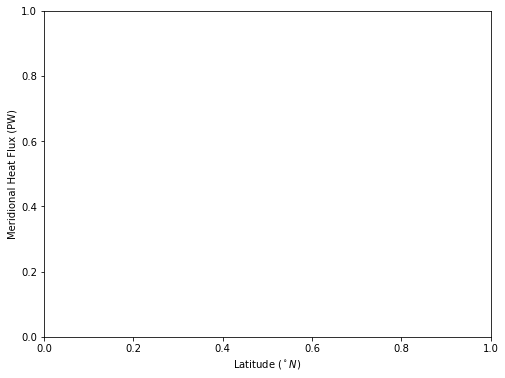

In [17]:
# plot both surface heat flux, temp_yflux_adv methods and observations:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF_intz(ekey)

    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dk',capsize=5,label='GW2003')
plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend(loc=2)
plt.xlim([-90.,90.])
plt.ylim([-2, 2.5])

savefigure('meridional_heat_transport_intz_withobs')

In [8]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_lastcycle_ocean_month.nc_net_sfc_heating_-12_days-since-1718-01-01_-87658_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_month.nc_net_sfc_heating_-34_days-since-1718-01-01_-87658_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_net_sfc_heating_None_days-since-0001-01-01_None_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


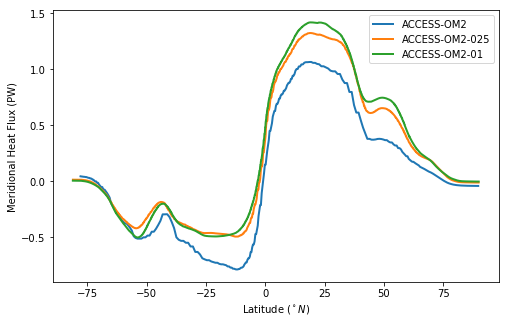

In [9]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')

In [30]:
# Infer from surface heat flux:
def find_AtlMHF(ekey):
    
    #get masks
    NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'
    if ekey == '1deg':
        Ocean_File = os.path.join(NYFCntrlDir,'om2_1_amoc_mask.nc')
        cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
        
        n_files = exptdata.exptdict[ekey]['n_files']
        print(n_files)
        n_files = -1
        #n_files = -12                          ## Last 12 files is last 60 years
        
    elif ekey == '025deg':
        Ocean_File = os.path.join(NYFCntrlDir,'om2_025_amoc_mask.nc')
        cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
        
        n_files = exptdata.exptdict[ekey]['n_files']
        print(n_files)
        #n_files = -34                          ## Last 34 files is last 60 years
        n_files = -1
    
    elif ekey == '01deg':
        ekey='1deg'
        Ocean_File = os.path.join(NYFCntrlDir,'om2_1_amoc_mask.nc')
        cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
        
        n_files = exptdata.exptdict[ekey]['n_files']
        print(n_files)
        n_files = -1
        #Ocean_File = os.path.join(NYFCntrlDir,'om2_01_amoc_mask_newdims.nc')
        #cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
        
        #n_files = exptdata.exptdict[ekey]['n_files']
        #print(n_files)
        #n_files = -1
        #n_files = None                          ## For Testing
        
    #ekey='1deg'
    expt = exptdata.exptdict[ekey]['expt']
    print(expt)
    
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    print(shflux.shape)
    shflux_am=shflux.resample(time='A').mean('time').load()
    print(shflux_am.shape)
    #shflux_am = shflux.mean('time').sel(time=slice(708,720)).load()
            
    mask=cntrl.kmu[0].load()
    mask=np.nan_to_num(mask)
    print(mask.shape,shflux_am.shape)
    
    shflux_am=shflux_am.mean('time')#*mask
    print(shflux_am.shape)
    
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

In [ ]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Atlantic Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    print(ekey)
    print(latv.shape,MHF.shape)
    latv, MHF = find_AtlMHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('Atlantic meridional_heat_transport')

1deg
(300,) (300,)
1deg_jra55v13_iaf_spinup1_B1_lastcycle
-12
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_lastcycle_ocean_month.nc_net_sfc_heating_-1_days-since-1718-01-01_-87658_False.pkl
(60, 300, 360)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(5, 300, 360)
(300, 360) (5, 300, 360)
(300, 360)
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
025deg
(300,) (300,)
025deg_jra55v13_iaf_gmredi6
-34
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_month.nc_net_sfc_heating_-1_days-since-1718-01-01_-87658_False.pkl
(12, 1080, 1440)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(1, 1080, 1440)
(1080, 1440) (1, 1080, 1440)
(1080, 1440)
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [ ]:
NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'

Ocean_File = os.path.join(NYFCntrlDir,'om2_1_amoc_mask.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.kmu.shape)
mask=cntrl.kmu[0].load()
mask=np.nan_to_num(mask)
print(mask.shape)

In [ ]:
#try this method
expt = '1deg_jra55v13_iaf_spinup1_B1'  ## choosing our 1 degree experiment
n_files = -12                          ## Last 12 files is last 60 years
time_units = 'days since 1718-01-01'   ## These are to give correct dates
offset = -87658


shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)

print(shflux.shape)
shflux= shflux.resample(time='A').mean('time')
#print(shflux_am.shape)
    
shflux_am=shflux*mask
print('resampled',shflux_am.shape)

area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()

MHF = np.zeros((60,latv.shape[0]))
print(MHF.shape)

for t in range(60):
    tmp1=shflux_am[t,:]
    tmp2 = np.zeros_like(latv)
    
    for i in range(len(latv)):
        inds = lat < latv[i]
        tmp2[i] = np.sum(area.where(lat < latv[i])*tmp1.where(lat < latv[i]))

    print(t,tmp2.shape,MHF.shape)
    MHF[t,:] = tmp2 + (tmp2[0]-tmp2[-1])/2

## Plot the mean for the North Atlantic region
#psi.mean('time').plot.contourf(levels=np.arange(-29,30,2))

## Save the whole dataset
#MHF.to_netcdf('ATl_MHT_1deg.nc')

print(MHF.shape)
a=np.save('ATl_MHT_1deg.npy',MHF)


In [ ]:
NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'

Ocean_File = os.path.join(NYFCntrlDir,'om2_025_amoc_mask.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl.kmu.shape)
mask=cntrl.kmu[0].load()
mask=np.nan_to_num(mask)
print(mask.shape)

In [ ]:
expt = '025deg_jra55v13_iaf_gmredi6'
n_files = -34                          ## Last 30 files is last 60 years
time_units = 'days since 1718-01-01'   ## These are to give correct dates
offset = -87658

shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)

print(shflux.shape)
#shflux_am = shflux.mean('annual').load()
#print(shflux_am.shape)
    
print(shflux.shape)
shflux= shflux.resample(time='A').mean('time')
#print(shflux_am.shape)
    
shflux_am=shflux*mask
print('resampled',shflux_am.shape)

area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
print(shflux.shape)
shflux= shflux.resample(time='A').mean('time')
#print(shflux_am.shape)
    
shflux_am=shflux*mask
print('resampled',shflux_am.shape)

area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()

MHF = np.zeros((60,latv.shape[0]))
print(MHF.shape)

for t in range(60):
    tmp1=shflux_am[t,:]
    tmp2 = np.zeros_like(latv)
    
    for i in range(len(latv)):
        inds = lat < latv[i]
        tmp2[i] = np.sum(area.where(lat < latv[i])*tmp1.where(lat < latv[i]))

    print(t,tmp2.shape,MHF.shape)
    MHF[t,:] = tmp2 + (tmp2[0]-tmp2[-1])/2

## Plot the mean for the North Atlantic region
#psi.mean('time').plot.contourf(levels=np.arange(-29,30,2))

## Save the whole dataset
#MHF.to_netcdf('ATl_MHT_1deg.nc')

print(MHF.shape)
a=np.save('ATl_MHT_025deg.npy',MHF)

## Plot the mean for the North Atlantic region
#psi.mean('time').plot.contourf(levels=np.arange(-29,30,2))

## Save the whole dataset
#MHF.to_netcdf('ATl_MHT_1deg.nc')

print(MHF.shape)
a=np.save('ATl_MHT_025deg_monthly.npy',MHF)
